<p>
    <strong>Idea</strong>: Combine <a href="https://arxiv.org/pdf/1802.03916.pdf">BBSE (Lipton et al ICML '18)</a> with <a href="https://arxiv.org/pdf/2007.08479.pdf">MALLS' (Zhao et al AISTATS '21)</a> subsampling technique while using <a href="http://proceedings.mlr.press/v70/finn17a/finn17a.pdf">MAML (Finn et al ICML '17)</a> to reduce bias in importance sampling weights learned from medial distribution and focus on domain adaptation on label shift.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
import math
import time
from collections import Counter, deque, OrderedDict

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F

from model import Network

In [2]:
#set reproducibility
np.random.seed(0)
_ = torch.manual_seed(0)

In [3]:
X, y = load_digits(return_X_y=True) #multiclassification

In [4]:
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

## Create Imbalanced Dataset

In [5]:
def group_by_label(y):
    """ Groups data by label and returns indices per label """
    label_dict = {}
    for i in range(len(y)):
        if y[i] in label_dict:
            label_dict[y[i]].append(i)
        else: 
            label_dict[y[i]] = [i]
        
    return dict(OrderedDict(sorted(label_dict.items())))

In [6]:
def dirichlet_distribution(alpha, idx_by_label, size, no_change=False):
    """ Create Imbalanced data using dirichlet distribution """
    class_composition = np.array([len(idx_by_label[k]) for k in sorted(idx_by_label.keys())], np.int64)
    print("Original Class composition: ", class_composition)
    
    if no_change:
        dataset = []
        for v in idx_by_label.values():
            dataset += v
        return dataset
    
    distribution = np.random.dirichlet([alpha]*len(idx_by_label), size=())
    idx_by_label = idx_by_label.copy()
    
    
    #Group data by label
    for label in idx_by_label:
        class_size = math.ceil(size * distribution[label])
        if not class_size:
            class_size = 1 #min number to support A.2 assumption (BBSE ICML '18)
        indices = np.random.randint(0,
                                   len(idx_by_label[label]),
                                   size=(class_size, ))
        idx_by_label[label] = np.unique([idx_by_label[label][i] for i in indices]).tolist()
    
    class_composition = np.array([len(idx_by_label[k]) for k in sorted(idx_by_label.keys())], np.int64)
    print("Shifted Class composition: ", class_composition)
        
    #Build new dataset of indices
    dataset = []
    for v in idx_by_label.values():
        dataset += v
    return dataset #shifted distribution

In [7]:
idx_by_label = group_by_label(y_train) #label : [indices of all labels]

In [8]:
train_ratio = 1
data_cap = int(X_train.shape[0])
size = int(data_cap * (train_ratio / (train_ratio + 1)))

In [9]:
shifted_dist_idx = dirichlet_distribution(alpha=0.5, idx_by_label=idx_by_label, size=size, no_change=False)

Original Class composition:  [145 154 144 149 135 135 146 145 144 140]
Shifted Class composition:  [ 27  34  18  18  63  31   1   1  60 133]


In [10]:
def get_distribution(labels):
    """ Returns the distribution of classes as ratios """
    dist = dict(Counter(labels))
    total_size = 0
    for key, value in dist.items():
        total_size += value
    
    for key in dist:
        dist[key] /= total_size
        
    return dict(OrderedDict(sorted(dist.items())))

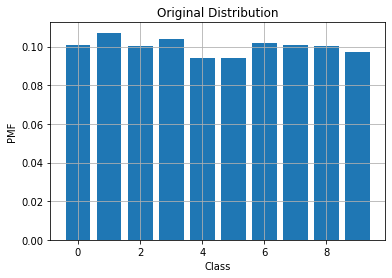

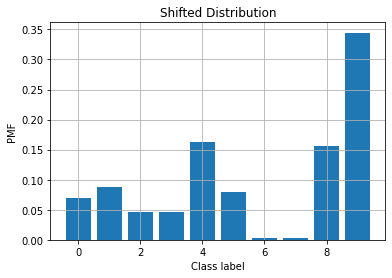

In [11]:
### Original Distribution
plt.bar(x=np.unique(y_train), height=get_distribution(y_train).values())
plt.title("Original Distribution")
plt.xlabel("Class")
plt.ylabel("PMF")
plt.grid()
plt.show()

### Shifted Distribution
plt.bar(x=np.unique(y_train[shifted_dist_idx]), height=get_distribution(y_train[shifted_dist_idx]).values())
plt.title("Shifted Distribution")
plt.xlabel("Class label")
plt.ylabel("PMF")
plt.grid()
plt.show()

## Sync With Data

In [12]:
X_train, y_train = X_train[shifted_dist_idx], y_train[shifted_dist_idx]

In [13]:
#Get source (train) and target (test) label distributions
dist_train = get_distribution(y_train)
dist_test  = get_distribution(y_test)

print(f"Train distribution : {dist_train}")
print(f"Test distribution : {dist_test}")

Train distribution : {0: 0.06994818652849741, 1: 0.08808290155440414, 2: 0.046632124352331605, 3: 0.046632124352331605, 4: 0.16321243523316062, 5: 0.08031088082901554, 6: 0.0025906735751295338, 7: 0.0025906735751295338, 8: 0.15544041450777202, 9: 0.344559585492228}
Test distribution : {0: 0.09166666666666666, 1: 0.07777777777777778, 2: 0.09166666666666666, 3: 0.09444444444444444, 4: 0.12777777777777777, 5: 0.13055555555555556, 6: 0.09722222222222222, 7: 0.09444444444444444, 8: 0.08333333333333333, 9: 0.1111111111111111}


## Train Model

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

In [15]:
##typecast to tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [16]:
# implement backprop
loss_function = nn.CrossEntropyLoss()

In [17]:
def train(data, epochs=500, epsilon=1e-2, print_st=False):
    """
    Train the model.
    Assumes access to global variable: loss function
    """
    X_train, y_train = data #extract info
    
    start_time = time.time()
    losses = []

    model = Network().to(device) #load local model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    for i in range(epochs):
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        
        if loss.item() < epsilon:
            if print_st:
                print(f"Model Converged at epoch {i + 1}, loss = {loss.item()}")
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if print_st:
        print(f"Total training time (sec): {time.time() - start_time}, loss - {loss.item()}")

    return model, losses

In [18]:
model, cost = train((X_train, y_train), print_st=True)

Model Converged at epoch 79, loss = 0.00997946783900261
Total training time (sec): 0.1466350555419922, loss - 0.00997946783900261


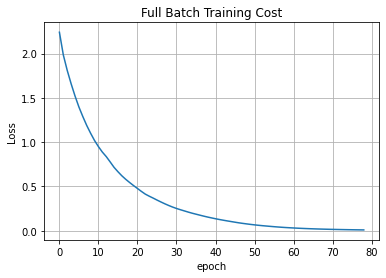

In [19]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Full Batch Training Cost")
plt.grid()
plt.show()

### Test Model

In [20]:
def predict(model, traininig_points=0):
    """ Predict accuracy => y_hat = f(x). Refer to BBSE, ICML '18 """
    
    model.eval() #set to evaluation mode
    # predict X_test data
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(X_test):
            y_pred = model(data)
            predictions.append(y_pred.argmax().item())

    predictions = np.array(predictions, dtype=np.int16)
    score = accuracy_score(y_test, predictions)
    return score, predictions

In [21]:
### Estimated distribution
score, predictions = predict(model)
print(f"Test Accuracy : {score}")

Test Accuracy : 0.7833333333333333


# BSSE 

In [22]:
delta = 0.05 #0 < delta < 1/k where k = number of classes.
validation_ratio = 0.5

In [23]:
#Split training into training (source) and validation (hold-out)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

In [24]:
### obtain classifier by training on X_train, y_train
f, cost = train((X_train, y_train), print_st=True)

Model Converged at epoch 72, loss = 0.009978615678846836
Total training time (sec): 0.06281280517578125, loss - 0.009978615678846836


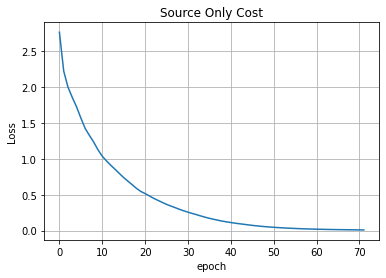

No IW test score : 0.7888888888888889


In [25]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Source Only Cost")
plt.grid()
plt.show()

### Estimated distribution
score, _ = predict(f)
print(f"No IW test score : {score}")

## Generate Label Shift

In [26]:
def calculate_confusion_matrix(X, Y):
    """ 
    Calculates value for \hat{C}_{\hat{y}, y}
    @Params:
    - X : Validation data, i.e. X2
    - Y : Validation labels, i.e. Y2
    """
    k = len(np.unique(y)) #number of classes
    conf_matrx = np.zeros(shape=(k, k))
    #freeze params
    f.eval()
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(X):
            y_pred = f(data)
            predictions.append(y_pred.argmax().item())
    
    predictions = np.array(predictions)
    for i in range(k):
        for j in range(k):    
            idxs = np.where((predictions == i) & (Y.numpy() == j))[0]
            conf_matrx[i, j] = float(len(idxs) / len(X))
    return conf_matrx, k

In [27]:
def calculate_target_priors(X, k):
    """ Calculates \hat{μ}_\hat{y} """
    preds = np.array([f(xp).argmax().item() for xp in X], np.int16)
    target_priors = np.zeros(k)
    for i in range(k):
        target_priors[i] = len(np.where(preds == i)[0]) / len(preds)
    return target_priors

In [28]:
conf_matrix, k = calculate_confusion_matrix(X_validation, y_validation)

In [29]:
mu = calculate_target_priors(X_test, k)

In [30]:
def compute_weights(cmf, target_priors):
    """ Computes label weights """
    
    try:
        label_weights = np.linalg.inv(cmf) @ mu
    except np.linalg.LinAlgError:
        label_weights = np.linalg.inv(cmf + np.random.uniform(0, 1e-6, size=cmf.shape)) @ target_priors
    
    label_weights[label_weights < 0] = 0 #strictly set rare occurances to 0 instead of abs (see BBSE)
    return label_weights

In [31]:
label_weights = compute_weights(conf_matrix, mu)

## Generate Importance Weights

In [ ]:
## TODO